In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from matplotlib import pyplot as plt
import numpy as np

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Prepare dataset with shuffle enabled
data = tf.keras.utils.image_dataset_from_directory(
    './data/Combined/', 
    image_size=(256, 256), 
    batch_size=32, 
    shuffle=True  # Shuffle data
)

# Data Augmentation: Applied to the training data using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30, 
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Split sizes
data_size = tf.data.experimental.cardinality(data).numpy()
train_size = int(data_size * 0.7)
val_size = int(data_size * 0.2)
test_size = int(data_size * 0.1)

# Prepare the datasets
train = data.take(train_size).map(lambda x, y: (x / 255, y))  # Normalize the training data
val = data.skip(train_size).take(val_size).map(lambda x, y: (x / 255, y))  # Normalize validation data
test = data.skip(train_size + val_size).take(test_size).map(lambda x, y: (x / 255, y))  # Normalize test data

# Apply data augmentation to the training set
train = train.map(lambda x, y: (tf.image.random_flip_left_right(x), y))

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

# Unfreeze the top layers of the base model
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

# Build the model with regularization, batch normalization, and additional layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # More efficient than Flatten()
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(9, activation='softmax')  # Output layer for 9 classes
])

# Compile the model with learning rate scheduler
initial_learning_rate = 1e-3
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate * 10 ** (-epoch / 20))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# TensorBoard callback for visualization
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)

# Train the model
hist = model.fit(
    train, 
    epochs=50, 
    validation_data=val, 
    callbacks=[early_stopping, tensorboard_callback, lr_schedule, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test)
print(f'Test accuracy: {test_acc:.4f}')

# Ensure the directory exists
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the model to the 'models' directory
model_path = os.path.join(model_dir, 'palm_tree_health_model.h5')
model.save(model_path)
print(f'Model saved to {model_path}')


Found 3662 files belonging to 9 classes.


/var/folders/n9/t793s4995b354q_1jpbvkkl40000gn/T/ipykernel_19445/3313137397.py:149: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.2719 - loss: 3.7025 - val_accuracy: 0.2133 - val_loss: 12.4554 - learning_rate: 0.0010
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.5306 - loss: 2.6276 - val_accuracy: 0.1726 - val_loss: 12.1392 - learning_rate: 8.9125e-04
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.6070 - loss: 2.2453 - val_accuracy: 0.1562 - val_loss: 13.3146 - learning_rate: 7.9433e-04
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.7111 - loss: 1.9190 - val_accuracy: 0.2024 - val_loss: 7.3013 - learning_rate: 7.0795e-04
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.7719 - loss: 1.7485 - val_accuracy: 0.2296 - val_loss: 9.9821 - learning_rate: 6.3096e-04
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.7969 - loss: 1.6128 - val_accuracy: 0.2582 - val_loss: 4.5042 - learning_rate: 5.6234e-04
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.8250 -

Test accuracy: 0.8892
Model saved to models/palm_tree_health_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


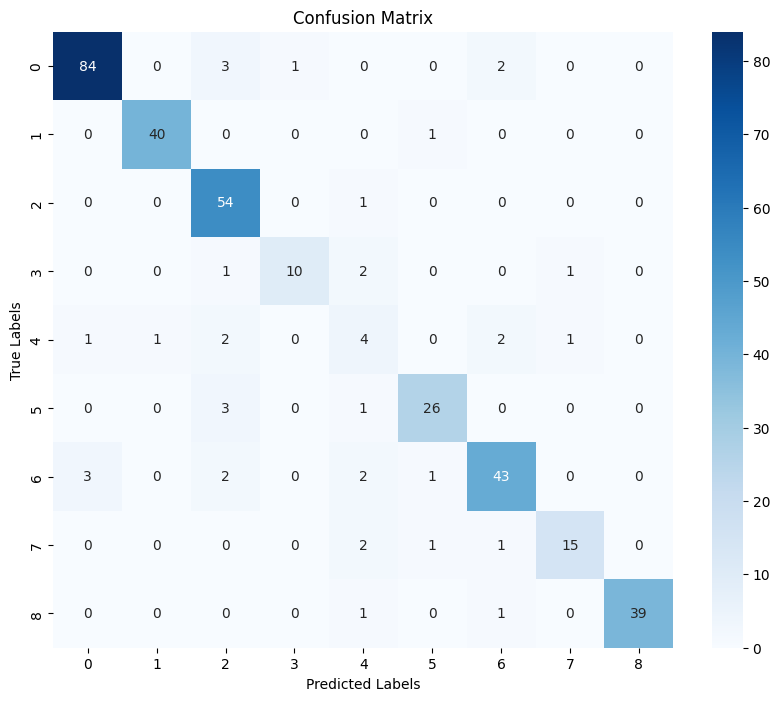

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        90
           1       0.98      0.98      0.98        41
           2       0.83      0.98      0.90        55
           3       0.91      0.71      0.80        14
           4       0.31      0.36      0.33        11
           5       0.90      0.87      0.88        30
           6       0.88      0.84      0.86        51
           7       0.88      0.79      0.83        19
           8       1.00      0.95      0.97        41

    accuracy                           0.89       352
   macro avg       0.85      0.82      0.83       352
weighted avg       0.90      0.89      0.90       352



In [15]:
true_labels = []
predicted_labels = []

for x, y in test:
    true_labels.append(y.numpy())  # Get the true labels
    predictions = model.predict(x)
    predicted_labels.append(np.argmax(predictions, axis=1))  # Get the predicted labels

true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print(classification_report(true_labels, predicted_labels))
